<center>
<div class="alert alert-block alert-info">
<h1>Data Modeling</h1>
    </div>

<a id=menu></a>
## Menu

* [Imports](#imports)
* [Add Customers with Unknown ID](#add_nans)
* [Linear Regression](#linear_reg)
    * [Linear Regression Hyperparameter Tuning](#lrhypertune)
* [KNearest Neighbor](#knn)
* [RandomForestRegressor](#rf)
* [ARIMA](#arima)


<a id=imports></a>
## Imports

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [504]:
data_path = '../cleaned_data'
file_path = '/clean_sales_df.csv'

In [3]:
os.listdir(data_path)

['rfm_data.csv',
 'clean_sales_df.csv',
 'kmeans_4_groups.csv',
 'data_with_all_customers.csv',
 'rfm_data.pkl',
 'hierchichal_4_groups.csv',
 'clean_sales_df.json']

In [505]:
#import data
data = pd.read_csv(data_path+file_path, index_col = 0,parse_dates = ['InvoiceDate'])
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01 00:00:00,100.8,2009,12,1,4,49,1,335
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01 00:00:00,30.0,2009,12,1,4,49,1,335


In [506]:
data.shape

(770448, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770448 entries, 0 to 1067369
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      770448 non-null  int64         
 1   StockCode    770448 non-null  object        
 2   Description  770448 non-null  object        
 3   Quantity     770448 non-null  int64         
 4   InvoiceDate  770448 non-null  datetime64[ns]
 5   Price        770448 non-null  float64       
 6   Customer ID  770448 non-null  int64         
 7   Country      770448 non-null  object        
 8   Date         770448 non-null  object        
 9   Revenue      770448 non-null  float64       
 10  Year         770448 non-null  int64         
 11  Month        770448 non-null  int64         
 12  Day          770448 non-null  int64         
 13  Quarter      770448 non-null  int64         
 14  Week         770448 non-null  int64         
 15  Week_day     770448 non-null  int

In [507]:
#rename revenu to sales
data.rename(columns={'Revenue':'Sales'},inplace=True)

<a id=add_nans></a>
### Add Customers with No ID

>Import the dataframe with guest customers, who have no ID and add it to my dataframe, because all I care about are the sales 

In [508]:
#read in the dataframe with all customers
all_data = pd.read_csv(data_path + '/data_with_all_customers.csv',index_col=0)
#include only unknown customers
nan_customers = all_data[all_data['Customer ID'].isna()]
nan_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,length_stockCodes,digit_number,letter_number
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,2009-12-01 00:00:00,6,5,1
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,2009-12-01 00:00:00,5,5,0
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,5,5,0
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,2009-12-01 00:00:00,5,5,0
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,5,5,0


In [509]:
#making sure customer id is all nans
nan_customers.shape[0], nan_customers['Customer ID'].isna().sum()

(237137, 237137)

In [510]:
#drop extra columns and add Sales
nan_customers.drop(['length_stockCodes','digit_number','letter_number'],axis=1,inplace=True)
nan_customers['Sales'] = nan_customers['Quantity']*nan_customers['Price']
nan_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,2009-12-01 00:00:00,0.55
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,2009-12-01 00:00:00,0.85
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,2.95
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,2009-12-01 00:00:00,15.00
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,8.85


In [511]:
#lets see how much sales do the guest customers account for
print('Guest customers account for: {}% of all sales'.format((nan_customers.Sales.sum()/data.Sales.sum() *100).round(2)))

Guest customers account for: 16.22% of all sales


In [512]:
#add all missing columns
nan_customers['Year'] = pd.DatetimeIndex(nan_customers.Date).year
nan_customers['Month'] = pd.DatetimeIndex(nan_customers.Date).month
nan_customers['Day'] = pd.DatetimeIndex(nan_customers.Date).day
nan_customers['Quarter'] = pd.DatetimeIndex(nan_customers.Date).quarter
nan_customers['Week'] = pd.DatetimeIndex(nan_customers.Date).week
nan_customers['Week_day'] = pd.DatetimeIndex(nan_customers.Date).weekday
nan_customers['Day_of_year'] = pd.DatetimeIndex(nan_customers.Date).dayofyear
nan_customers.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,2009-12-01 00:00:00,0.55,2009,12,1,4,49,1,335
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,2009-12-01 00:00:00,0.85,2009,12,1,4,49,1,335


In [513]:
#merge data and nan_customers dataframes
df = pd.concat([data, nan_customers],axis=0)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01 00:00:00,100.8,2009,12,1,4,49,1,335
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01 00:00:00,30.0,2009,12,1,4,49,1,335


In [518]:
#drop products with no description
df = df[df['Description'].notna()]
#any weird description
(pd.Series(df['Description'].unique()).apply(lambda x: len(x))<2).sum()

0

### Investigate Sales

One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

Date’ is one of the important factors influencing sales and it acts as an independent variable. To put it simply, this is a time-series data i.e a series of data points ordered in time.

In [522]:
#The top 10 most lucrative products
imp_prod = df.groupby('StockCode')['Sales'].sum().sort_values(ascending=False).reset_index()[:10]
imp_prod

,StockCode,Sales
0,22423,192415.62
1,85123A,172163.36
2,85099B,124760.35
3,47566,80036.63
4,84879,76137.51
5,20725,64493.20
6,22086,60758.67
7,22386,56297.56
8,21931,55053.77
9,22411,50612.73


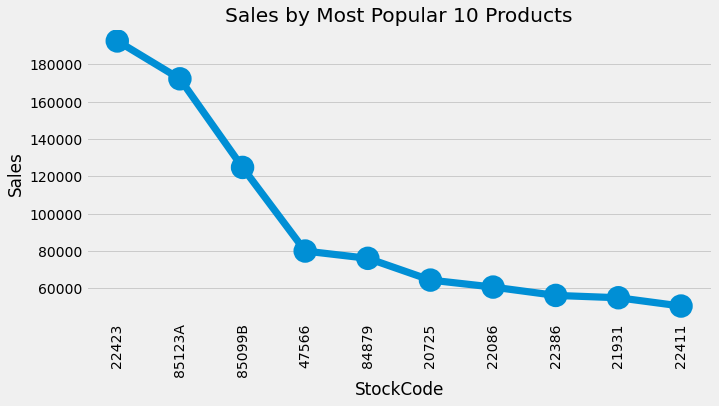

In [523]:
#plot the 10 most lurative products
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
sns.pointplot( x='StockCode',y='Sales',data=imp_prod)
plt.xticks(rotation=90)
plt.title('Sales by Most Popular 10 Products')
plt.show()

>Look at sales by quarter, month, day, year

In [524]:
#create a dataframe for monthly total sales
sales_monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()


In [525]:
#create a dataframe of sum monthly dollar sales 
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

sales_monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
sales_monthly['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly['Month_name'] = sales_monthly.Month.map(month_dict)

#create a dataframe of average monthly dollar sales 
sales_monthly_avg = df.groupby(['Year','Month'])['Sales'].mean().reset_index()
sales_monthly_avg['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly_avg['Month_name'] = sales_monthly.Month.map(month_dict)

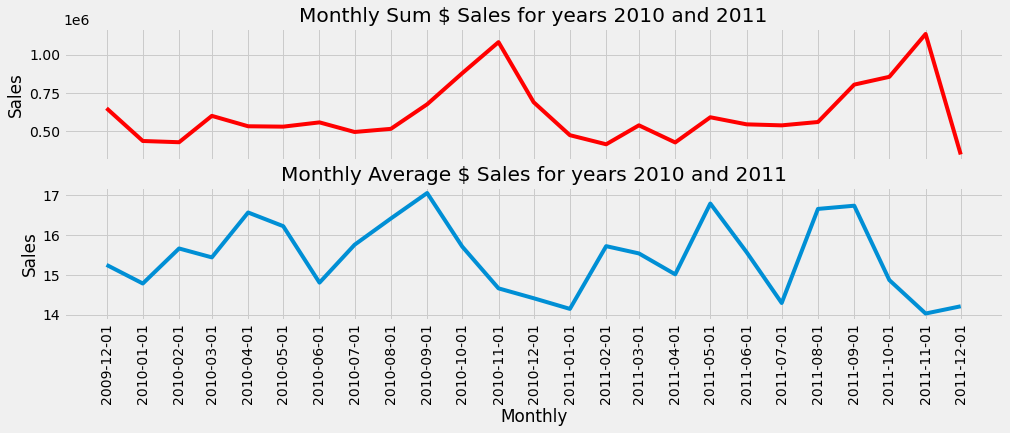

In [526]:
#plot monthly sales trend
x_ticks = sales_monthly_avg['Monthly'].dt.date
f,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

sns.lineplot(data=sales_monthly,x='Monthly',y='Sales',ax=ax[0],color='red')
ax[0].set_title('Monthly Sum $ Sales for years 2010 and 2011')

sns.lineplot(data=sales_monthly_avg,x='Monthly',y='Sales',ax=ax[1])
ax[1].set_title('Monthly Average $ Sales for years 2010 and 2011')

plt.xticks(x_ticks,rotation=90);

- In September 2010 there is a spike in average sales which then goes down but in sum of sales continues to rise, which means that the number of orders continues to increase of products of similar value. 

- In November there is a spike in sum of sales, which is probably the Christmas rush which starts slowing down in December, meaning that most people buy their gifts in November. Since this is an online store it makes sense that people would order gifts early so that they arrive on time. It is interesting to note that in November sum of sales goes up while average sales goes down, which means that there are many small orders. 



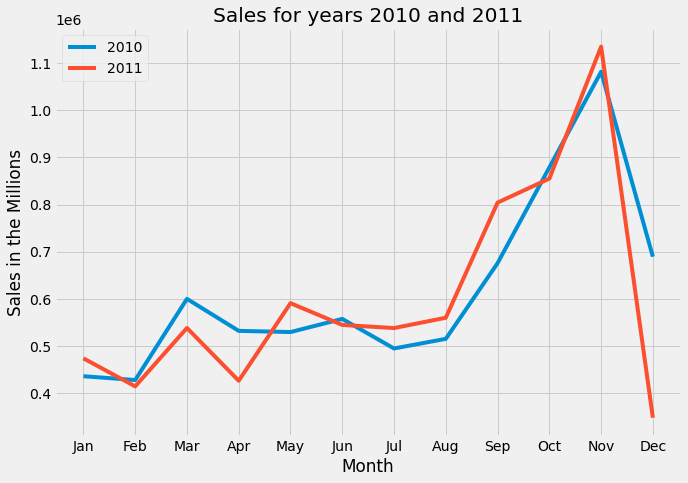

In [66]:
#plot sales for years 2010 and 2011
#plt.subplots(1,2,figsize=(7,7))
#sns.lineplot(data=sales_monthly,x='Monthly',y='Sales')
#plt.title('Sales for years 2010 and 2011')
plt.figure(figsize=(10,7))
sns.lineplot(data=sales_monthly[sales_monthly.Year==2010],x='Month_name',y='Sales',label=2010)
sns.lineplot(data=sales_monthly[sales_monthly.Year==2011],x='Month_name',y='Sales',label=2011)
plt.xlabel('Month')
plt.ylabel('Sales in the Millions')
plt.title('Sales for years 2010 and 2011');

>Both years follow the same sales trend with a noticeable increase in sales in November going into December for Christmas in both years, which is expected. This confirms that sales vary with date and that there is a seasonality factor present in the data.

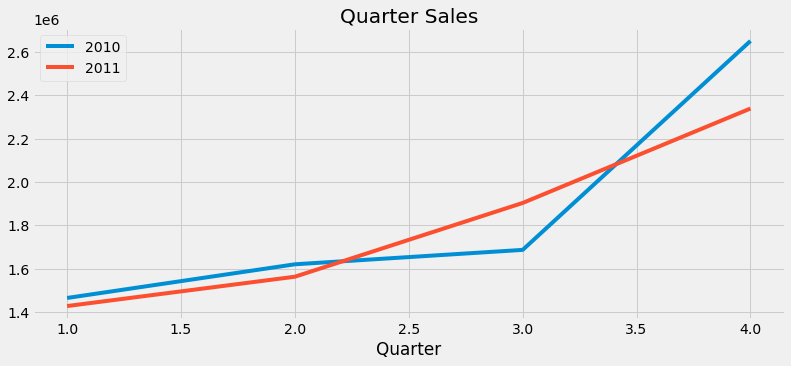

In [67]:
#plot quarterly 
plt.figure(figsize=(12,5))
df[df.Year==2010].groupby('Quarter')['Sales'].sum().plot(label=2010)
df[df.Year==2011].groupby('Quarter')['Sales'].sum().plot(label=2011)
plt.legend()
plt.title('Quarter Sales');

>There is an increase at last quarter because of the increased sales for Christmas

In [68]:
#look at daily sum of sales
day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thr',4:'Fri',5:'Sat',6:'Sun'}
daily_sum = df.groupby('Week_day')['Sales'].sum().reset_index()
daily_avg = df.groupby('Week_day')['Sales'].mean().reset_index()

daily_sum['Week_day']=daily_sum.Week_day.map(day_dict)
daily_avg['Week_day']=daily_avg.Week_day.map(day_dict)
daily_sum 

,Week_day,Sales
0,Mon,2.582799e+06
1,Tue,2.937707e+06
2,Wed,2.788371e+06
3,Thr,3.051502e+06
4,Fri,2.325299e+06
5,Sat,9.518430e+03
6,Sun,1.611165e+06


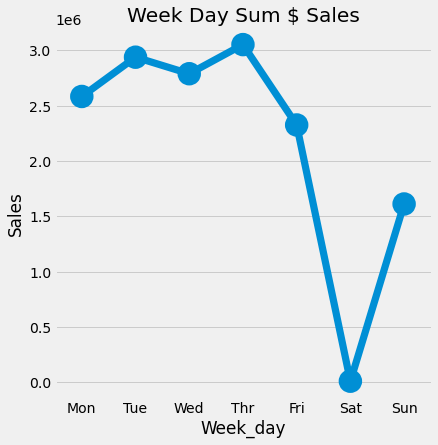

In [69]:
#plot daily sum of sales
sns.factorplot(data=daily_sum,x='Week_day',y='Sales',size=6, aspect=1)

plt.title('Week Day Sum $ Sales');

>Sales seem to decrease on Saturday, which makes sense since this data is for an online store people would go out on Saturday and make their orders on Sunday.

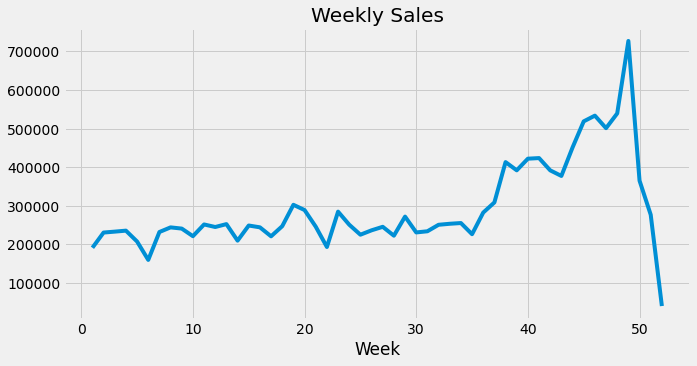

In [70]:
#look at weekly sum of sales
plt.figure(figsize=(10,5))

df.groupby('Week')['Sales'].sum().plot()
plt.title('Weekly Sales');

>Again sales increase by end of year

Text(0.5, 1.0, 'Sum Sales per Year')

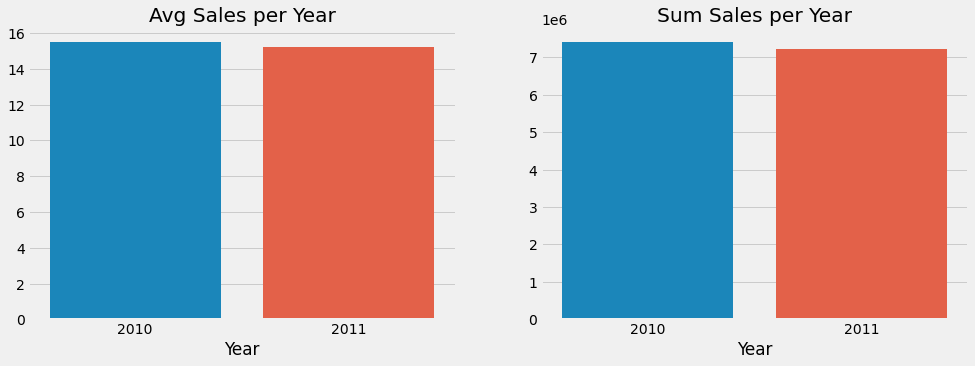

In [71]:
#look at average sales for year 2009 and 2010
yearly_avg = df[df.Year>2009].groupby('Year')['Sales'].mean()
yearly_sum = df[df.Year>2009].groupby('Year')['Sales'].sum()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=yearly_avg.index, y=yearly_avg.values)
plt.title('Avg Sales per Year')
plt.subplot(1,2,2)

sns.barplot(x=yearly_sum.index, y=yearly_sum.values)
plt.title('Sum Sales per Year')


>There is a slight decrease in average and sum of sales from 2010 to 2011, which could mean that there is less orders being made

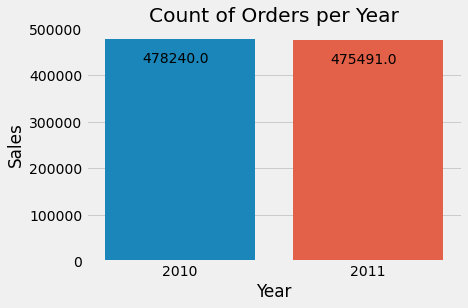

In [72]:
#investigate the number of orders per year
yearly_count = df[df.Year>2009].groupby('Year')['Sales'].count().reset_index()
#yearly_sum = data[data.Year>2009].groupby('Year')['Sales'].sum()
p = sns.barplot(x=yearly_count.Year, y=yearly_count.Sales)
for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-50000))

plt.title('Count of Orders per Year');


>the number of orders made has gone down but only slightly

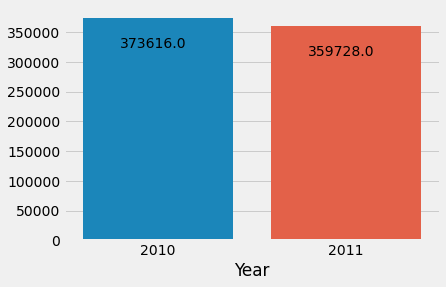

In [73]:
#Investigare number of customers per year
yearly_customers = df[df.Year>2009].groupby('Year')['Customer ID'].count()
p=sns.barplot(x=yearly_customers.index, y=yearly_customers.values)

for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-50000))

>also the number of customers has gone down slightly

>In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.

>so to check if time series is stationary there are tow tests, the rolling mean and the Dicky Fuller Test

[Back to Menu](#menu)

<a id='linear_reg'></a>
### Linear Regression

> Metrics used:
- Rsquared: measures the strength of the relationship between the model and the dependent variable. equal to 1-rss/tss (rss/tss represents the variation of y not described by the regression line and rss is y - predicted y and tss is y-ymean). If Rsquared is close to 1 then the model explains the dependent variable well, if it is low then the model does not represent the variance of y and model is not better than taking the mean, if it negative then it does not explain y at all and it is worse than the mean
- Mean Squared Error: the average of the squared difference between the predicted and actual value. It has a convex shape and it penalizes large errors
- Mean Absolute Error: the average of the absolute difference between the predicted and actual values. It does not do great if there are many outliers, as in my case. It does not penalize large errors but it shrinks unimportant features to zero

>The response variable needs to be somewhat normal with no outliers since outliers affect the performance of predictive algorithms

<AxesSubplot:xlabel='Sales'>

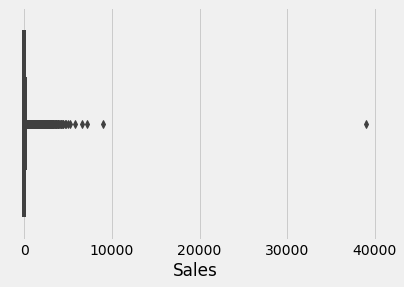

In [515]:
#display sales, the target variable, boxplot
sns.boxplot(df.Sales)

In [516]:
#There are many outliers 99% of sales is
df.Sales.quantile(0.99)

179.0

(996365, 17)


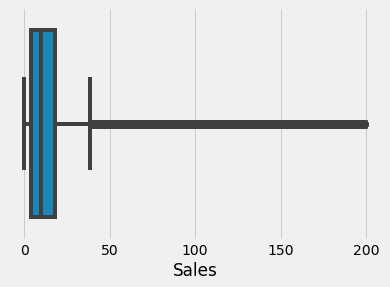

In [517]:
#remove all the 0 price because they are not sales, and keep 99% of the data
df = df[df.Sales != 0]

df = df[df.Sales<=200]
print(df.shape)
#boxplot of new sales variable
sns.boxplot(df.Sales);

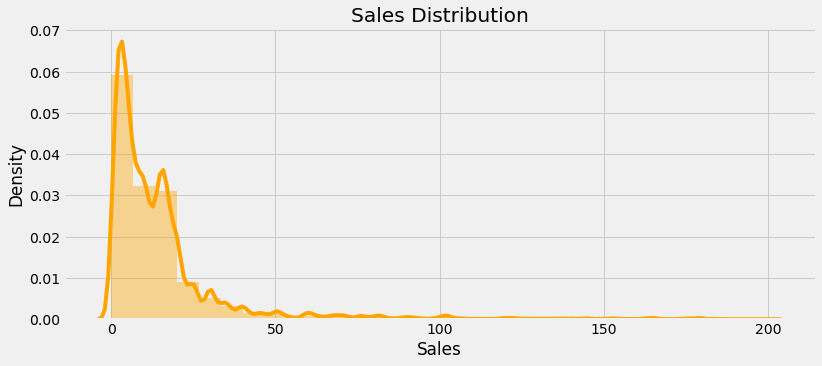

In [519]:
#plot Sales distribution
plt.figure(figsize=(12,5))
sns.distplot(df.Sales,bins=30,kde=True,color='orange')
plt.title('Sales Distribution');

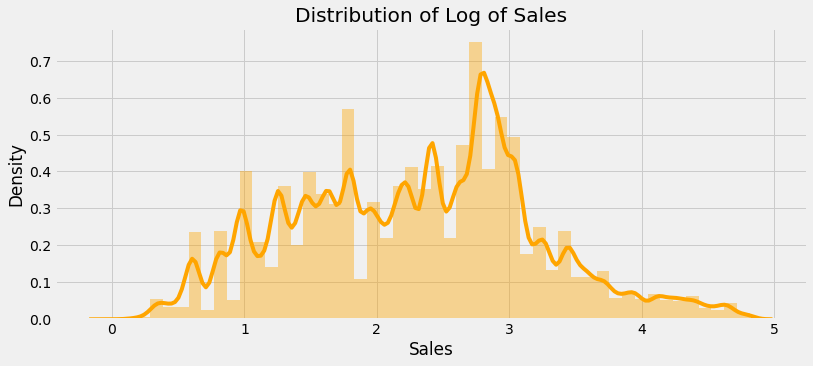

In [520]:
#log(x+1) of Sales 
plt.figure(figsize=(12,5))
sns.distplot(np.log1p(sales_test),color='orange',kde=True)
plt.title('Distribution of Log of Sales');

>The distribution of log of sales has shorter right tail and looks closer to a normal distribution. 

>Kurtosis is a measure of the peakiness of a distribution, or is a measure of how heavy the tails are. So kurtosis of normal distribution is 0.0. If less than 0 then light tailed, greater than 0 the distribution is heavy tailed, or most of the data is in the tails. Skew is a measure of symmetry of the data. An absolute measurement between 0 and 0.5 for skew and kurtosis means the data is said to be symmetric 

In [521]:
#measure skew and kurtosis
print('skew = ', df.Sales.skew().round(2),'kurtosis= ',df.Sales.kurt().round(2))
print('skew log sales',(np.log1p(df.Sales)).skew().round(2),'kurtosis log sales= ',(np.log1p(df.Sales)).kurt().round(2))

skew =  4.08 kurtosis=  21.61
skew log sales 0.24 kurtosis log sales=  -0.15


<AxesSubplot:>

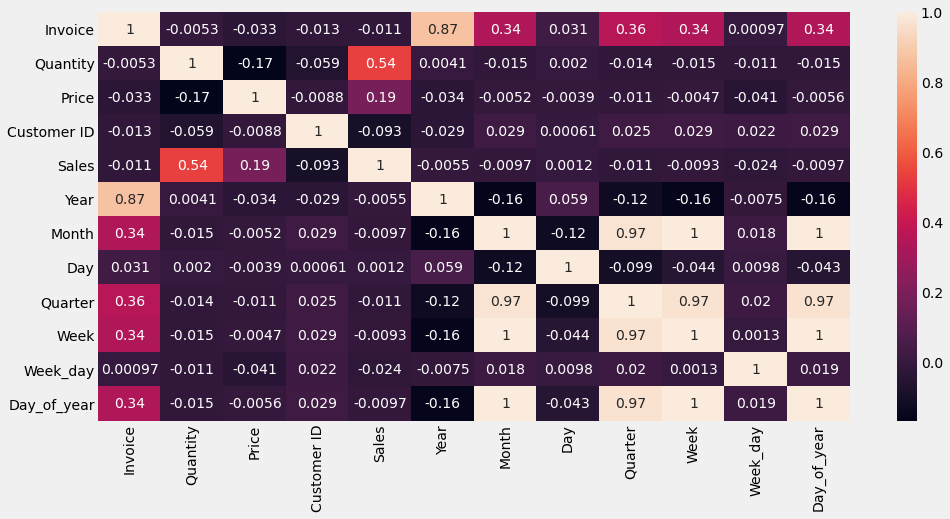

In [75]:
#look at correlation between variables
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True)

>It is important that the features are not correlated. The target variable, Sales is not correlated with any other variable other than quantity, which makes sense since it is calculated using sales. The other time features are correlated which is expected in a datetime series. Next the features and target variables will be created. All the irrelevant features, like invoice, description and customer ID, will be dropped.

In [81]:
#create X and y variables
X = df[['Year','Month','Day','Quarter','Week','Week_day','Day_of_year']]
#scale the independent variable X
X_scaled = StandardScaler().fit_transform(X)
y = df['Sales'].values
y_log = np.log1p(df['Sales']).values

In [82]:
#create training and test datasets, one with y and another with log y
#I will test if the model performs better for the log of sales
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=123)
X_train,X_test,y_train_log,y_test_log = train_test_split(X_scaled,y_log,test_size=0.2,random_state=123)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((797092, 7), (199273, 7), (797092,), (199273,))

In [83]:
#linear regression model, and the coefficient of determination for the training independent variable and 
#the training dependent variable to see how well the training data fit the response variable
lr_model = LinearRegression().fit(X_train,y_train)
lr_model.score(X_train,y_train)

0.0009125114249850519

In [84]:
#linear regression model for log y and score for log y
lr_model_log = LinearRegression().fit(X_train,y_train_log)
lr_model_log.score(X_train,y_train_log)


0.002454894862228163

>R squared value is very small which means that the model fits the data very poorly

In [499]:
#predict with model
y_pred = lr_model.predict(X_test)
y_pred_log = lr_model_log.predict(X_test)

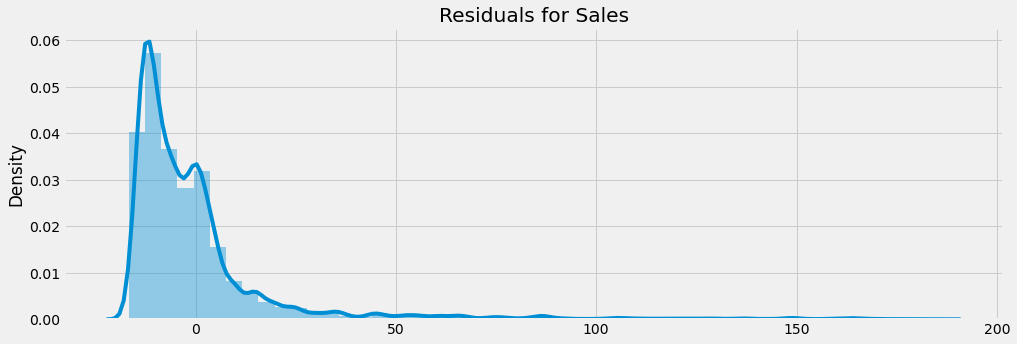

In [500]:
#plot residuals of sales
plt.figure(figsize=(15,5))
sns.distplot(y_test - y_pred)
plt.title('Residuals for Sales');

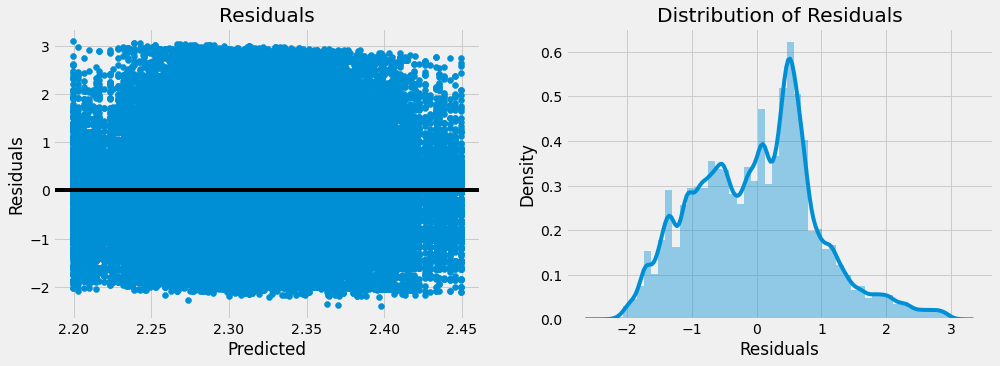

In [530]:
#plot residuals with log sales
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_log,y_test_log - y_pred_log)

ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_log - y_pred_log,ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals');

>I get better spread, closer to normal distribution residuals for log y. For residuals,since it is actual - predicted, positive values, which is on the y-axis, mean the prediction was too low, and negative values mean the prediction was too high; 0 means the prediction was exactly correct. Residuals are spread out around 0 with no pattern, which is what we want.

In [90]:
#function that take y and y predictions and 
#returns r_squared, MSE, RMSE, MAE
def metrics(y,y_pred):
    return 'r_square: ', r2_score(y,y_pred).round(5), \
        'MSE: ',mean_squared_error(y,y_pred).round(2), \
        'RMSE: ',np.sqrt(mean_squared_error(y,y_pred)).round(2),\
        'MAE: ',mean_absolute_error(y,y_pred).round(2)

In [91]:
#create an array of mean to test metrics if mean was our prediction to get a sense of values mean
y_mean = np.empty_like(y_test)
y_mean.fill(y.mean())

In [92]:
#metrics for y_test and prediction
print('y: ',metrics(y_test,y_pred))
#metrics for log y_test and predictions
print('log y: ',metrics(y_test_log,y_pred_log))
#metrics for y_test and if my prediction was the mean
print('mean y: ',metrics(y_test,y_mean))

y:  ('r_square: ', 0.00074, 'MSE: ', 454.55, 'RMSE: ', 21.32, 'MAE: ', 11.94)
log y:  ('r_square: ', 0.00224, 'MSE: ', 0.89, 'RMSE: ', 0.94, 'MAE: ', 0.77)
mean y:  ('r_square: ', -0.0, 'MSE: ', 454.88, 'RMSE: ', 21.33, 'MAE: ', 11.94)


>Looking at the metrics it is apparent that using y without laking the log is worse than using the mean as prediction. Using log y gives better results, but coefficient of determination is small, indicating that the model fits the data very badly. The RMSE is smaller for log y

In [111]:
#I will use the statsmodel ordinary least squares model
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train_log, X_train_sm).fit() #formula='Sales ~ TV', data=data
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     280.2
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        01:19:29   Log-Likelihood:            -1.0856e+06
No. Observations:              797092   AIC:                         2.171e+06
Df Residuals:                  797084   BIC:                         2.171e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3183      0.001   2191.239      0.0

>The coefficients for each feature in X all have a very small p_value, which means they are statistically significant 
>Like in the linear regression R_squared is very small, which means that the X features explain only 0.3 of the variance of the sales. The p of F_statistic is significant. F_statistic is the ratio of mean squared error of the model to the mean squared error of residuals. It determines the overall significance of the model.It tests if the coefficient are significant jointly and in this case they are.
>As expected the linear regression is not a good model for predicting sales

<a id='lrhypertune'></a>
#### Hyperparameter tuning

In [112]:
#cross validation
lr_results = cross_val_score(lr_model_log, X_train, y_train_log, cv=5, \
                     scoring= 'r2')
lr_results

array([0.00270739, 0.00242754, 0.00281071, 0.00222809, 0.00197636])

>I don't get better results. R2 is still very low

[Back to Menu](#menu)

<a id = 'knn'></a>
### KNearest Neighbor

>Knearest Neighbor is a model that adapts well to classification and regression. It is also easy to implement and to interpret. However, one drawback is its inability to adapt to highly complex relationships between the independent and dependent variables. So I will test it and see how it will perform

<AxesSubplot:>

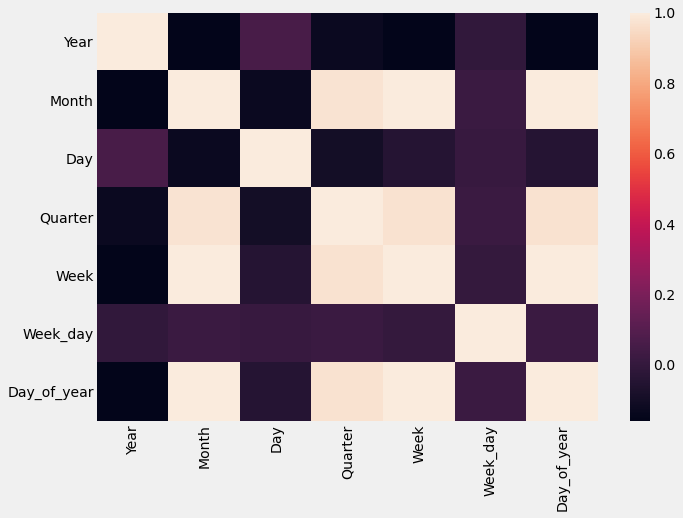

In [113]:
plt.figure(figsize=(10,7))
sns.heatmap(X.corr())

>The randomizedSearch is taking too long because my data is too big so I will reduce it to year 2011 since both years have the same trends more or less 

In [116]:
df_reduced = df[df.Year ==2011]
X_reduced = df_reduced[['Year','Month','Day','Quarter','Week','Week_day','Day_of_year']]
#scale the independent variable X_reduced
X_scaled_red = StandardScaler().fit_transform(X_reduced)

y_log_red = np.log1p(df_reduced['Sales']).values
len(y_log_red)

475491

In [117]:
#create training and test datasets, one with y and another with log y
X_train_red,X_test_red,y_train_red,y_test_red = train_test_split(X_scaled_red,y_log_red,test_size=0.2,random_state=123)

X_train_red.shape,X_test_red.shape,y_train_red.shape,y_test_red.shape


((380392, 7), (95099, 7), (380392,), (95099,))

In [118]:
#paramaters to be tuned for kneighbors regressor are the number of neighbors and if the closest points get more weight
#(distance) or no weight (uniform)
seed=123
kfold =KFold(n_splits=5,shuffle=True,random_state=seed)  #shuffle=True,
param_grid={"n_neighbors": range(1, 20),'weights':['uniform','distance']}

knn = KNeighborsRegressor()

grid_knn = RandomizedSearchCV(knn, param_distributions=param_grid,cv=3,scoring='r2',
                             n_jobs=-1,verbose=10)
#grid_knn_2 = RandomizedSearchCV(knn, param_distributions=param_grid_2,cv=3,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=10)

knn_model = grid_knn.fit(X_train_red,y_train_red)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [119]:
#best parameters
knn_model.best_params_


{'weights': 'uniform', 'n_neighbors': 18}

In [120]:
#predict
y_pred_knn = knn_model.predict(X_test_red)
metrics(y_test_red,y_pred_knn)

('r_square: ', -0.01924, 'MSE: ', 0.93, 'RMSE: ', 0.96, 'MAE: ', 0.78)

>r2 is negative but the errors are reduced with MAE at 0.79, lets look at the residuals

count    95099.000000
mean        -0.012100
std          0.964779
min         -2.925607
25%         -0.717463
50%          0.022885
75%          0.612114
max          3.614996
dtype: float64


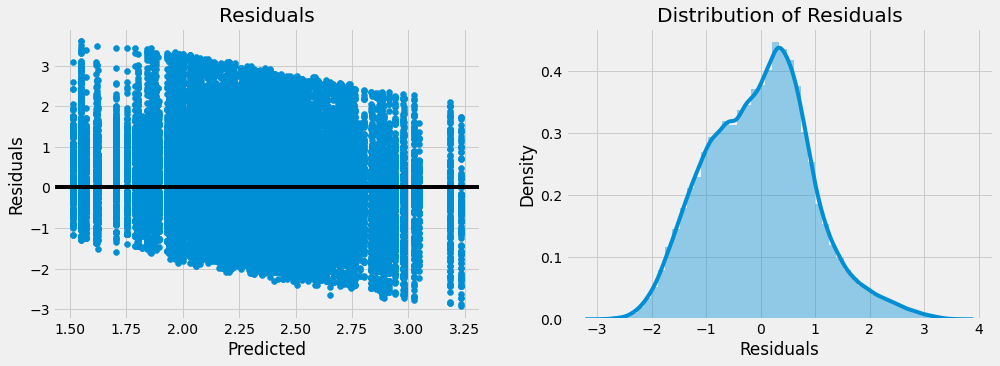

In [531]:
#plot residuals vs actual
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_knn, y_test_red-y_pred_knn)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_red-y_pred_knn, ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals')
print(pd.Series(y_test_red-y_pred_knn).describe());

>There is a clear pattern, which means that the model does not work for the data, however, the distribution of residuals are almost normal centered around 0.01, so they are almost normally distributed but model is predicting very badly.

[Back to Menu](#menu)

<a id='rf'></a>
### RandomForestRegressor

In [125]:
# Number of trees in random forest
n_estimators = [200,400,800] #[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]#num is number of samples to generate
# Minimum number of samples required to split a node
min_samples_split = [2,5,10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

params_rf = {'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}
print(params_rf)

{'n_estimators': [200, 400, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [126]:
#run RandomizedSearc with the parameter grid then fit to data
rf = RandomForestRegressor()
grid_random_forest = RandomizedSearchCV(estimator=rf,param_distributions=params_rf,
                                        scoring='neg_root_mean_squared_error',
                                       n_iter=10, verbose=10,n_jobs=-1, cv=3)
rf_model = grid_random_forest.fit(X_train_red,y_train_red)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [127]:
#predict with rf_model
y_pred_rf = rf_model.predict(X_test_red)
metrics(y_test_red,y_pred_rf)

('r_square: ', 0.0412, 'MSE: ', 0.88, 'RMSE: ', 0.94, 'MAE: ', 0.76)

count    95099.000000
mean        -0.001101
std          0.935810
min         -2.506287
25%         -0.703630
50%          0.039520
75%          0.598484
max          3.375207
dtype: float64


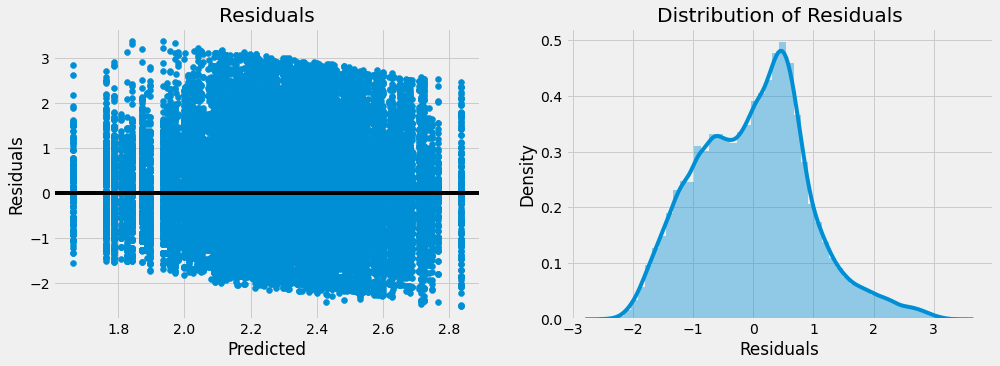

In [532]:
#plot residuals vs actual
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_rf, y_test_red - y_pred_rf)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_red-y_pred_rf, ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals')
print(pd.Series(y_test_red-y_pred_rf).describe());

>Again there are patterns in residual plot so the model is not predicting well and it needs to be improved. This is expected because ensemble methods don't do well with datetime series, The residuals are almost normally distributed and centered around -0.001.

In [132]:
#metrics for the three models
print('Linear Regression: ',metrics(y_test_log,y_pred_log),
    '\nnearest neighbor:',metrics(y_test_red,y_pred_knn),
    '\nRandom Forest: ',metrics(y_test_red,y_pred_rf))

Linear Regression:  ('r_square: ', 0.00224, 'MSE: ', 0.89, 'RMSE: ', 0.94, 'MAE: ', 0.77) 
nearest neighbor: ('r_square: ', -0.01924, 'MSE: ', 0.93, 'RMSE: ', 0.96, 'MAE: ', 0.78) 
Random Forest:  ('r_square: ', 0.0412, 'MSE: ', 0.88, 'RMSE: ', 0.94, 'MAE: ', 0.76)


>random forest gave better scores than knn and linear regression with slightly better r2 and errors. However, looking at residual plots, linear regression gave the best prediction. The R2 is low for all models, which means that variance of the dependent variable(sales) is not well explained by the variance of the independent variables in my data, so more features could be added to improve the score, like lags, however I will try ARIMA and see if it performs better.

<a id='arima'></a>
### Autoregressive Integrated Moving Average or ARIMA

> ARIMA the most commonly used methods for time-series forecasting.
>In order to use ARIMA model, I need to ensure that the time series data is stationary, meaning constant mean, constant variance and constant covariance with time. A time series is stationary if a single shift in time does not change the time series statistical properties. The reason for this is that the term AR means Auto Regressive, which means it is a linear regression model that uses its own lags as predictors. Linear regression models, work best when the predictors are not correlated and are independent of each other.  

>There are two ways to test if a dataseries is stationary  
        1. Rolling mean  
        2. Dicky_Fuller_test

In [389]:
#copy the dataframe
df_data = df.copy()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)

In [390]:
#change index to be the dates without the time
df_data = df_data.set_index('InvoiceDate')#InvoiceDate has time
df_data.index = df_data.index.normalize()#gets rid of time stamp
df_data.head(2)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
InvoiceDate,,,,,,,,,,,,,,,,
2009-12-01,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
2009-12-01,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


<AxesSubplot:xlabel='InvoiceDate'>

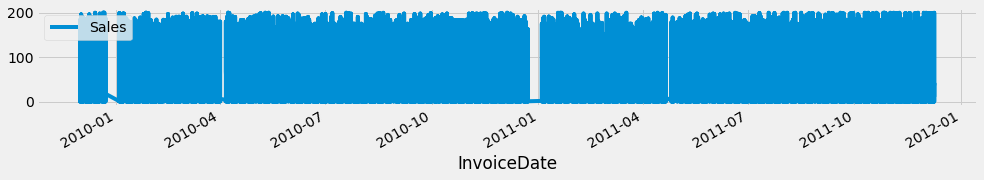

In [391]:
#create a df with only sales
df_sales = df_data[['Sales']]
#visualize
df_sales.plot(figsize=(15,2))

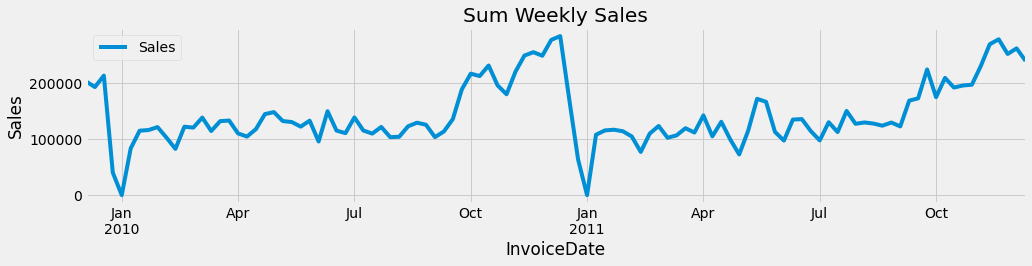

In [392]:
#resample weekly and plot 
df_sales.resample('W').sum().plot(figsize=(15,3))
plt.title('Sum Weekly Sales')
plt.ylabel('Sales');

>sales tend to peak at the end of the year then go down in January

> ### Rolling mean: 
The window of one week is rolled across the data and an average is taken. Then I can compare the original data with the rolled data and check if the data is stationary or not by visualization. If original data and rolled data look similar, it means that the mean and variation does not change over time and that they are constant, so no transformation is necessary

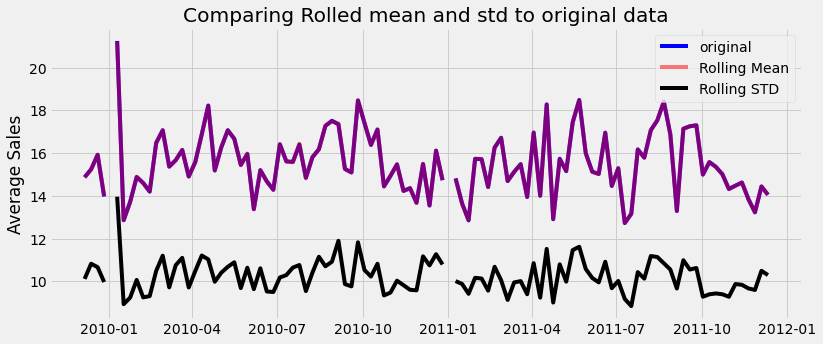

In [393]:
roll_mean = df_sales.rolling(window=7).mean()
roll_std = df_sales.rolling(window=7).std()

plt.figure(figsize=(12,5))
original = plt.plot(df_sales.resample('W').mean(),color='blue',label='original')
mean = plt.plot(roll_mean.resample('W').mean(),color='red',label='Rolling Mean',alpha=0.5)
std = plt.plot(roll_std.resample('W').mean(),color='black',label='Rolling STD')
plt.legend()
plt.ylabel('Average Sales')
plt.title('Comparing Rolled mean and std to original data');


>### The Dicky_Fuller_test: 
it tests the null hypothesis that the data is not stationary and the alternative hypothesis is that the data is stationary. If the p-value is less than the critical value, 0.05 I will reject the null hypothesis and say that data is stationary.

In [394]:
#Dicky_Fuller_test
df_sales_m = df_sales.resample('W').sum()
result = adfuller(df_sales_m, autolag='AIC')
print('ADF Statistic={}\np_value= {}\n'.format(result[0],result[1]))
print('Critical Values = ' ,result[4])

ADF Statistic=-3.3154770124328494
p_value= 0.014200668045446965

Critical Values =  {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}


>From the graph the rolling mean falls on top of the original data which means that it follows the same trends. From the Dicky_Fuller test the ADF statistic is below 5% critical value and its p_value is 0.0025 which is less than 5% which makes it significant. This means that I can reject the null hypothesis that the series is not stationary and accept the alternate hypothesis that the series is stationary. So there is no need to do any transformation (like differencing) on it.


ARIMA is a class of models that explains a given time series based on its own past values, 
Arima stands for Autoregressive Integrated Moving Average, which means the following:
AR stands for Autoregression, which means a model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated which means subtracting an observation from an observation at the previous time step in order to make the time series stationary or differencing
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

There are three parameters that need to be tuned:
- p is the number of lags of Y to be used as predictors
- d is the minimum number of differencing needed to make the series stationary. A d =0 means the series is stationary 
- q refers to the number of lagged forecast errors that should go into the Model.



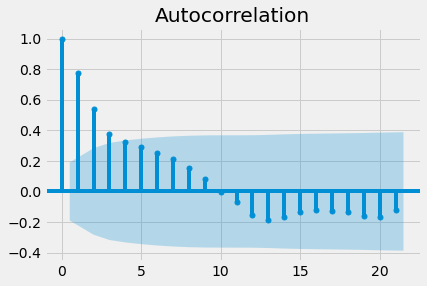

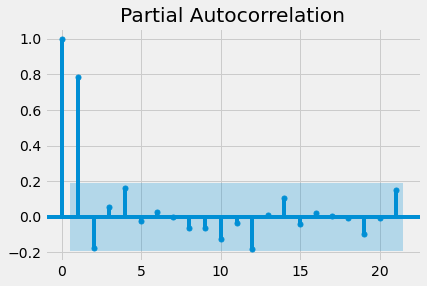

In [400]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#The ACF plot tells how many MA terms are required to remove any autocorrelation in the stationarized series, which is q
plot_acf(df_sales_m.values)
#To find out need needs any AR terms or p by inspecting the Partial Autocorrelation (PACF) plot.
plot_pacf(df_sales_m.values);

>from autocorrelation graph 1,2 are significant so I will try q=2 and from the pacf graphs 1 and 2 are significant so I will try p=1

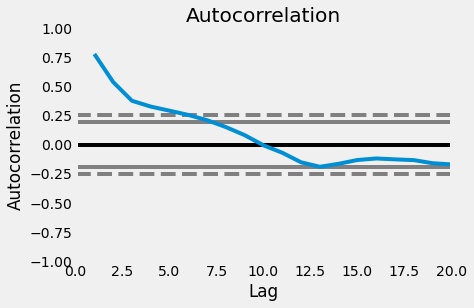

In [243]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_sales_m).set_xlim([0, 20])
plt.title('Autocorrelation');

>There is significant correlation at 1, 2, 3, and 4 and positive correlation until 5, so it makes sense to use 3 as a starting point 

>Create training and test sets that are 75/25 of data. The order of the data need to be kept because the 
order sequence of the time series should be intact in order to use it for forecasting.
ARIMA has a forecast function that, by default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information.

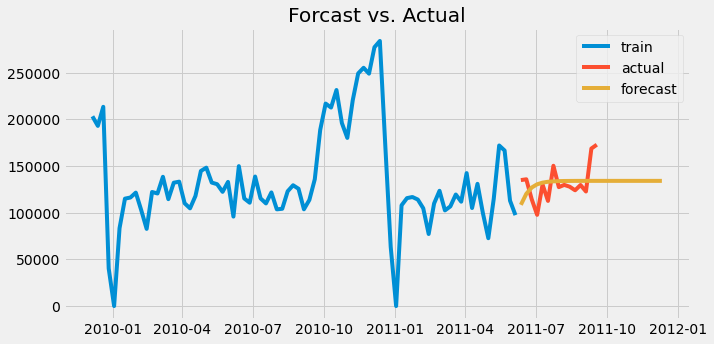

In [401]:
#create training and test sets that are 75/25 of data. The order of the data need to be kept because the 
#order sequence of the time series should be intact in order to use it for forecasting.


X = df_sales_m.values
size = int(len(df_sales_m)*0.75)
train, test = X[0:size], X[size:len(X)]
predictions = []
model = ARIMA(train, order=(1,0,2))
model_arima = model.fit()
fc, er, ci = model_arima.forecast(len(test))#forecast 15 steps
fc_series = pd.Series(fc, index=df_sales_m[size:].index)

#plot forcast
plt.figure(figsize=(10,5))
plt.plot(df_sales_m[0:size], label='train')
plt.plot(df_sales_m[size:size+15], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forcast vs. Actual')
plt.legend()

>forcast is not great so now I need to find the best values for p, d, and q

In [314]:
"""
Function that takes training, test sets and a list of values for p, d and q to test
Function loops through the values of p, d and q and creates a tuple of these values and calls evaluate_arima 
    that returns the root mean square error and then print the p,d,q for the model that gave the least RMSE
"""
def evaluate_model(train, test, p_val, d_val, q_val):
    #intialize best score to a large value
    best_score,best_pdq = float('inf'), ()
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order=(p,d,q)
                
                try:
                    #run arima
                    rmse=evaluate_arima(train, test, order)
                    #get error
                    if rmse < best_score:
                        best_score, best_pdq = rmse, order
                        
                        #print the order and its error
                    print('ARIMA order: {}, RMSE: {}'.format(order,rmse))
                except:
                    continue
    print('Best ARIMA order: {} with error = {}'.format(best_pdq, best_score))
                    

In [311]:
"""
Function takes in training and test sets and a tuple of p,d,q for arima model and fits and predicts the ARIMA 
returns the mean squared error
"""
def evaluate_arima(train,test,order):
    #all_data = train
    
    predictions = []
    for i in range(len(test)):
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        fc = model_fit.forecast()[0]
        predictions.append(fc)
    #calculate the mean squared error    
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    return rmse


In [459]:
size = int(len(df_sales_m)*0.75)


In [434]:
#call evaluate_model to iterate through values for p,d,q to a model with least RMSE
# create train and test set
X = df_sales_m.values
size = int(len(df_sales_m)*0.75)
train, test = X[0:size], X[size:len(X)]

#list of p, d and q values
p_values = [1, 2, 3, 4, 6]#, 8, 10]
d_values = range(0, 3)
q_values = range(0, 5)

#run function
evaluate_model(train,test,p_values, d_values, q_values)

ARIMA order: (1, 0, 0), RMSE: 86779.21584464044
ARIMA order: (1, 0, 1), RMSE: 84715.490368551
ARIMA order: (1, 0, 2), RMSE: 85125.03164365301
ARIMA order: (1, 0, 3), RMSE: 83521.72417603538
ARIMA order: (1, 0, 4), RMSE: 84069.05645585364
ARIMA order: (1, 1, 0), RMSE: 96106.42029856156
ARIMA order: (1, 1, 1), RMSE: 94046.9679092713
ARIMA order: (1, 1, 2), RMSE: 85334.47301203218
ARIMA order: (1, 1, 3), RMSE: 85442.68152351442
ARIMA order: (1, 1, 4), RMSE: 84094.44285115473
ARIMA order: (1, 2, 0), RMSE: 117365.9409629762
ARIMA order: (2, 0, 0), RMSE: 87213.36334897797
ARIMA order: (2, 0, 1), RMSE: 85098.06290354603
ARIMA order: (2, 0, 2), RMSE: 84733.95182493182
ARIMA order: (2, 0, 3), RMSE: 83945.94389482628
ARIMA order: (2, 0, 4), RMSE: 82016.02631815776
ARIMA order: (2, 1, 0), RMSE: 85010.0752353104
ARIMA order: (2, 1, 1), RMSE: 87501.87837287881
ARIMA order: (2, 1, 2), RMSE: 85436.68815582052
ARIMA order: (2, 1, 3), RMSE: 84255.25403693673
ARIMA order: (2, 1, 4), RMSE: 81886.18165275

In [490]:
#Run ARIMA with the new optimized values
model = ARIMA(train, order=(4,2,0))
model_fit = model.fit()
fc,se, conf_int = model_fit.forecast(steps=len(test))

forecast = pd.Series(fc, index = df_sales_m.index[size:])
lower_val = pd.Series(conf_int[:,0], index = df_sales_m.index[size:])
upper_val = pd.Series(conf_int[:,1], index = df_sales_m.index[size:])

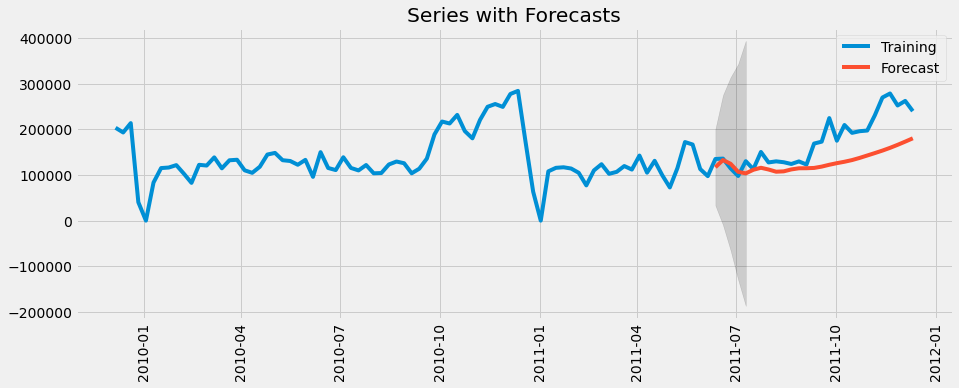

In [492]:
#plot forcast
plt.figure(figsize=(14,5))
plt.plot(df_sales_m, label='Training')
plt.plot(forecast, label='Forecast')
plt.fill_between(lower_val.index[:5], lower_val[:5], upper_val[:5], color='k', alpha=.15)
plt.xticks(rotation=90)
plt.title('Series with Forecasts')
plt.legend();

>The forecasts are trending up. I only show the first 5 values of the 95% confidence interval because the it goes up and we cannot see the forecasts

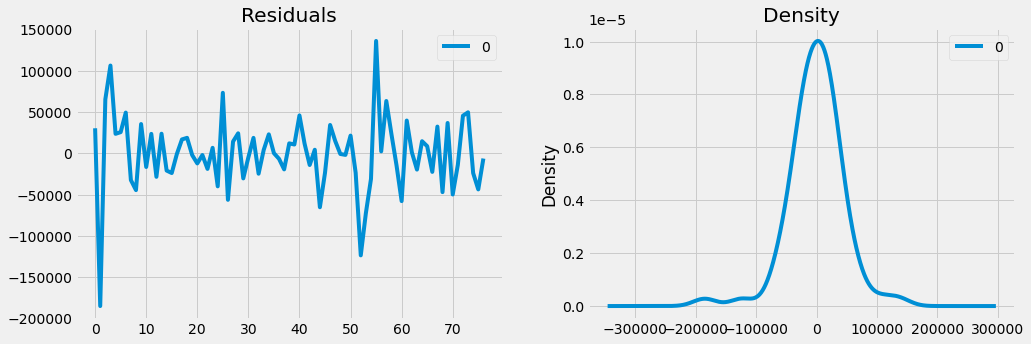

In [484]:
# Plot residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

>The residuals are normally distributed around 0

In [451]:
sales_diff = df_sales_m.diff().dropna()
X_i = sales_diff.values

size_i = int(len(X_i)*0.75)
train_i, test_i = X_i[0:size], X_i[size:len(X)]


p_values = [1, 2, 3, 4, 5, 6]
d_values = range(0, 4)
q_values = range(0, 4)

#run function
evaluate_model(train_i,test_i,p_values, d_values, q_values)

ARIMA order: (1, 0, 0), RMSE: 26708.294664045414
ARIMA order: (1, 0, 1), RMSE: 26075.4683523725
ARIMA order: (1, 0, 2), RMSE: 26088.26012713681
ARIMA order: (1, 0, 3), RMSE: 26059.25063330601
ARIMA order: (1, 1, 0), RMSE: 41409.149871818016
ARIMA order: (1, 2, 0), RMSE: 39533.55354583205
ARIMA order: (2, 0, 0), RMSE: 26179.65511050723
ARIMA order: (2, 0, 1), RMSE: 25648.378228833273
ARIMA order: (2, 0, 2), RMSE: 26060.838044795157
ARIMA order: (2, 0, 3), RMSE: 26417.94487899513
ARIMA order: (2, 1, 0), RMSE: 30139.475357070685
ARIMA order: (2, 2, 0), RMSE: 63011.2987075404
ARIMA order: (3, 0, 0), RMSE: 26386.483795525808
ARIMA order: (3, 0, 1), RMSE: 26474.11797251633
ARIMA order: (3, 0, 2), RMSE: 26121.41432521202
ARIMA order: (3, 0, 3), RMSE: 25691.27986281863
ARIMA order: (3, 1, 0), RMSE: 26457.555816361168
ARIMA order: (3, 2, 0), RMSE: 50552.74939951687
ARIMA order: (4, 0, 0), RMSE: 25505.707964232737
ARIMA order: (4, 0, 1), RMSE: 25795.158864358862
ARIMA order: (4, 0, 2), RMSE: 256

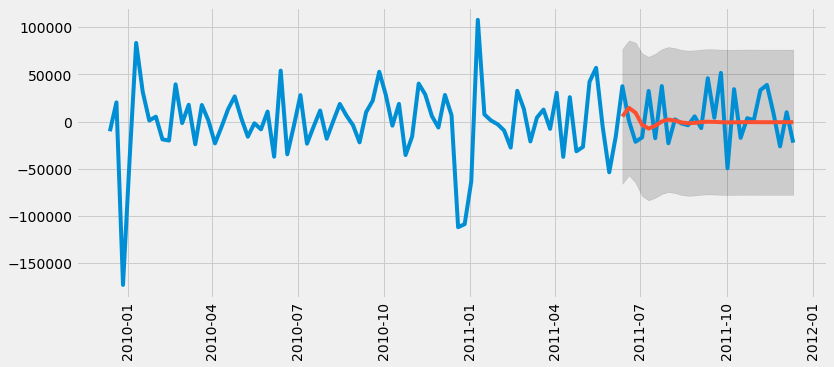

In [489]:
model = ARIMA(train_i, order=(4,0,0))
model_fit = model.fit()
fc,se, conf_int = model_fit.forecast(steps=len(test_i))

forecast_diff = pd.Series(fc, index = sales_diff.index[size_i:])
lower_val = pd.Series(conf_int[:,0], index = sales_diff.index[size_i:])
upper_val = pd.Series(conf_int[:,1], index = sales_diff.index[size_i:])

plt.figure(figsize=(12,5))
plt.plot(sales_diff, label='training')
plt.plot(forecast_diff, label='forecast')
plt.fill_between(lower_val.index, lower_val, upper_val, 
               color='k', alpha=.15)
plt.xticks(rotation=90);

>Forcast is trending up

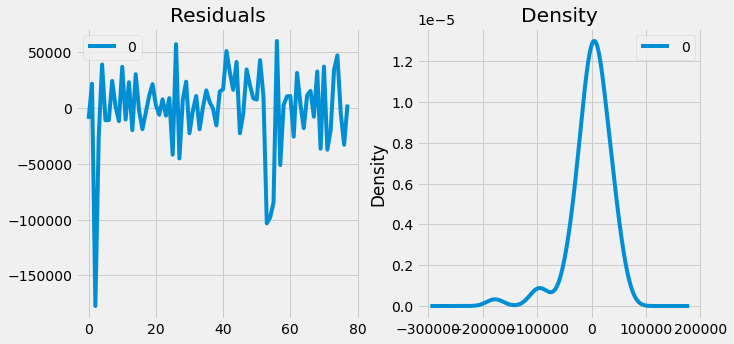

In [452]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize = (10,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
>Residuals seem to be normal centered around 0

In [498]:
df_sales_m.iloc[1]#[0:1]

Sales    193099.75
Name: 2009-12-13 00:00:00, dtype: float64